In [5]:
!pip install --upgrade tensorboard
!pip install -qqq pytorchcv pytorch-lightning

     |████████████████████████████████| 6.0 MB 9.2 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.4.0 requires tensorboard!=2.5.0,>=2.2.0, but you have tensorboard 2.5.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


# Approximate Inference in Bayesian Deep Learning: Getting Started in Pytorch

In this colab we will walk you through downloading the data, running your method and generating a submission for our NeurIPS 2021 competition. In this colab we use the Pytorch framework. For Jax see [this notebook](https://colab.research.google.com/drive/1SJ6waN8DOfby6qW9WWgJ0VLyaNzauhYD?usp=sharing).

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform](https://competitions.codalab.org/competitions/33647)


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

print(os.getcwd())
os.chdir("/content/drive/MyDrive/neurips_bdl_sirius2021")
print(os.getcwd())

/content
/content/drive/MyDrive/neurips_bdl_sirius2021


In [3]:
import sys
import math
import matplotlib
import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from pytorchcv.model_provider import get_model as ptcv_get_model
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

sys.path.append("neurips_bdl_starter_kit")
import pytorch_models as p_models
from loss_function import log_posterior_fn
from eval import get_accuracy_fn, evaluate_fn
from swag import train_SWAG
from data_loading import safe_load_numpy, NormClfDataset
from vram_stats import get_vram_usage_str

In [4]:
import pytorch_lightning as pl

In [5]:
x_train = safe_load_numpy("cifar10_train_x")
y_train = safe_load_numpy("cifar10_train_y")
x_test = safe_load_numpy("cifar10_test_x")
y_test = safe_load_numpy("cifar10_test_y")

In [6]:
x_train = x_train.reshape((len(x_train), 32, 32, 3))
x_test = x_test.reshape((len(x_test), 32, 32, 3))

In [7]:
# Split for validation
train_size = 0.9
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=train_size, stratify=y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


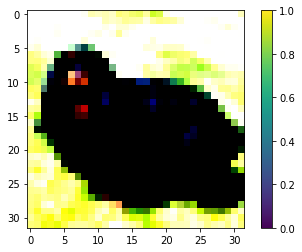

In [8]:
plt.imshow(x_train[666].reshape(32, 32, 3))
plt.colorbar()

In [21]:
trainset = NormClfDataset(x_train, y_train)
valset = NormClfDataset(x_val, y_val)
testset = NormClfDataset(x_test, y_test)

## Model and losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/torch_models.py` module. Here, we will load a ResNet-20 model with filter response normalization (FRN) and swish activations. The models are implemented in `pytorch`. 

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`). The `log_posterior_wgrad_fn` computes the posterior log-density and its gradients with respect to the parameters of the model.

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

In [11]:
net_fn2 = p_models.get_model("resnet20_frn_swish", data_info={"num_classes": 10})

In [15]:
#import torch.nn.utils.convert_parameters as convert
#len(convert.parameters_to_vector(net_fn.parameters())), len(convert.parameters_to_vector(net_fn2.parameters()))

## Optimization and training 

In this colab we train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines in jax [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

We run training for 5 epochs, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [25]:
class FastResNet(LightningModule):
    def __init__(self, net, prior_variance=5., lr=1e-3):
        super().__init__()
        self.net_fn = net

        self.prior_variance = 5.
        self.lr = lr

        self.save_hyperparameters()

        # compute the accuracy -- no need to roll your own!
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
    
    def forward(self, x):
        return self.net_fn(x)
    
    def loss(self, xs, ys):
        logits, log_post = log_posterior_fn(self, (xs, ys), 
                                            prior_variance=self.hparams["prior_variance"], 
                                            return_logits=True)
        return logits, -log_post

    def training_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        # logging metrics we calculated by hand
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        # logging a pl.Metric
        self.train_acc(preds, ys)
        self.log('train/acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])
    
    def test_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)

        self.test_acc(preds, ys)
        self.log("test/loss_epoch", loss, on_step=False, on_epoch=True, 
                 prog_bar=True)
        self.log("test/acc_epoch", self.test_acc, on_step=False, on_epoch=True, 
                 prog_bar=True)

    def validation_step(self, batch, batch_idx):
        xs, ys = batch
        logits, loss = self.loss(xs, ys)
        preds = torch.argmax(logits, 1)
        self.valid_acc(preds, ys)

        self.log("valid/loss_epoch", loss)  # default on val/test is on_epoch only
        self.log('valid/acc_epoch', self.valid_acc)
            
        return logits


In [26]:
batch_size = 256
test_batch_size = 100
num_epochs = 2
momentum_decay = 0.8
lr = 0.0001

prior_variance = 5.

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

In [27]:
net_fn3 = FastResNet(net_fn2, prior_variance=5., lr=1e-3)

In [30]:
trainer = pl.Trainer(
    gpus=-1,                # use all GPUs
    max_epochs=25,           # number of epochs
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [31]:
# fit the model
trainer.fit(net_fn3, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)

# evaluate the model on a test set
trainer.test(dataloaders=test_loader,
             ckpt_path=None)  # uses last-saved model


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | net_fn    | make_resnet_fn | 281 K 
1 | train_acc | Accuracy       | 0     
2 | valid_acc | Accuracy       | 0     
3 | test_acc  | Accuracy       | 0     
---------------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.124     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc_epoch': 0.7591999769210815, 'test/loss_epoch': 484796.625}
--------------------------------------------------------------------------------



[{'test/acc_epoch': 0.7591999769210815, 'test/loss_epoch': 484796.625}]

In [33]:
net_fn3 = net_fn3.cuda()
train_acc, all_train_probs = evaluate_fn(net_fn3, train_loader)
print("\tTrain accuracy: {}".format(train_acc))
test_acc, all_test_probs = evaluate_fn(net_fn3, test_loader)
print("\tTest accuracy: {}".format(test_acc))

	Train accuracy: 0.9621786221184514
	Test accuracy: 0.7591999810934067


In [34]:
import swag

# T = 200
# batch_size = 100

# teta, diag, D = swag.train_SWAG(net_fn, log_posterior_fn, trainset, T, batch_size)
T = 800
batch_size = 100

teta, teta_sqr, D = swag.train_SWAG(net_fn3, log_posterior_fn, trainset, 
                                    T, batch_size, c=20, K=20,
                                    lr=1e-5,
                                    prior_variance=1,)

<class 'function'>


In [37]:
import averaging

S = 5
diag = teta_sqr
all_test_probs_swag = averaging.average_models(net_fn3, test_loader, teta, diag, D, S)
all_test_probs_swag_np = all_test_probs_swag.cpu().numpy()

0.7793999791145325
0.7771999794244766
0.778299977183342
0.7770999783277511
0.7782999783754349


## Evaluating metrics

The starter kit comes with a script that can compute the agreement and total variation distance metrics used in the competition.

In [38]:
import metrics

We can load the HMC reference predictions from the starter kit as well.

In [39]:
with open('data/cifar10/probs.csv', 'r') as fp:
  reference = np.loadtxt(fp)

Now we can compute the metrics!

In [40]:
from sklearn.metrics import accuracy_score

swag_point = np.argmax(all_test_probs_swag_np, axis=-1)
acc = accuracy_score(swag_point, y_test)
agree = metrics.agreement(all_test_probs_swag_np, reference)
tvd = metrics.total_variation_distance(all_test_probs_swag_np, reference)

print(f"SWAG \t Acc: {acc:.2f} \t Agreement: {agree:.2f} \t TV distance: {tvd:.2f}")

SWAG 	 Acc: 0.78 	 Agreement: 0.80 	 TV distance: 0.22


## Preparing the submission

Once you run the code above, `all_test_probs` should contain an array of size `10000 x 10` where the rows correspond to test datapoints and columns correspond to classes.

In [41]:
all_test_probs_swag_np.shape

(10000, 10)

Now, we need to save the array as `cifar10_probs.csv` and create a zip archive with this file.

In [42]:
np.savetxt("cifar10_probs.csv", all_test_probs_swag_np)

!zip submission_swag_fast.zip cifar10_probs.csv

  adding: cifar10_probs.csv (deflated 55%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [ ]:
from google.colab import files
files.download('submission_swag.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system](https://competitions.codalab.org/competitions/33512?secret_key=10f23c1f-9c86-4a7a-8406-d85b0a0713f2#participate) and upload your submission. Good luck :)